## This approach will filter out unspecific diseases and group synonymous classes
### A EfficientNetb0 will be trained on those 

'alternaria leaf spot',
'bacterial blight',
 'bacterial spot',
 'bacterial_wilt',
 'black_measles',
 'black_rot',
 'blast',
 'brown_spot' (combined with septoria)
 'brown_streak_disease',
 'citrus_greening',
 'common rust', 
 'early_blight',
 'gray leaf spot',
 'healthy',
 'isariopsis_leaf_spot',
 'late blight' (combined with phytophora),
 'leaf_curl',
 'leaf_mold',
 'northern_leaf_blight',
 'powdery_mildew',
 'red_rot',
 'spider_mites',
 'target spot', 
 'tungro'
 'mosaic_disease' (combines with mosaic_virus),


leaf_blight also can be exclude (check)
leaf_curl is a condition not disease. (check)
leaf scorch (check)
pests (check)
nematode (check)
virus (check)
phytophthora (Phytophthora infestans is a devastating plant pathogen that causes late blight disease in potatoes.) should be merged with 
We should exclude yellow_leaf because it is condition not disease. (bearbeitet) (check)
mosaic disease not symtom (check)
gray spot
rust: not specific enough
scab: same
green mottle, too bad data coverage








In [38]:
import os
#Import nessesary packages, libraries and global variables

import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from  PIL import Image
import numpy as np
from tensorflow.keras import Input, Model
from tensorflow.keras.applications.efficientnet import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.utils import split_dataset
import tensorflow as tf
from tensorflow import keras
from keras import layers

import sys
sys.path.append('../modeling')

RSEED = 42
dataset_path = '../data/filtered_diseases/train_filtered/'

import tensorflow.keras.backend as K

In [40]:


data_path = '../data/filtered_diseases/train_filtered'
file_count = len(os.listdir(data_path))
file_count

27

In [41]:


def get_differing_files(dir1, dir2):
    return set(os.listdir(dir1)) ^ set(os.listdir(dir2))

dir1 = '../data/filtered_diseases/train_filtered'
dir2 = '../data/filtered_diseases/test_filtered'

differing_files = get_differing_files(dir1, dir2)
print("Differing files:", differing_files)

Differing files: set()


In [2]:
'''import shutil

source_dir = '../data/filtered_diseases/train_filtered/brown_spot/septoria_leaf_spot/'
destination_dir = '../data/filtered_diseases/train_filtered/brown_spot'

# Move the contents of the source directory to the destination directory
shutil.move(source_dir, destination_dir)'''

Error: Destination path '../data/filtered_diseases/train_filtered/brown_spot/septoria_leaf_spot' already exists

In [5]:
'''# Iterate over each item in the source directory
for item in os.listdir(source_dir):
    # Get the full path of the item
    item_path = os.path.join(source_dir, item)
    # Move the item to the destination directory
    shutil.move(item_path, destination_dir)'''

### short EDA

In [42]:
file_types = {}

def count_file_types(folder): 
    for root, dirs, files in os.walk(folder): 
        for file in files: # Get the file extension 
            file_extension = os.path.splitext(file)[1][1:].lower()
            file_types[file_extension] = file_types.get(file_extension, 0) + 1

folder_path = '../data/filtered_diseases/train_filtered/'
count_file_types(folder_path)

for file_type, count in file_types.items(): print(f"{file_type}: {count}")

: 2
jpg: 70884


In [15]:
def load_preprocess_split_train_val(data_path):
    ''' 
    Function needs filefath as parameter, it will create a validation dataset of 20% of the total df, 
    Needs an RSEED as global variable,
    Image will be cropped to 1:1 and altered to 224 x 224
    '''
    image = tf.keras.utils.image_dataset_from_directory(
        data_path, 
        validation_split = 0.2,
        subset = "both", 
        seed = RSEED,
        image_size = (224, 224),
        crop_to_aspect_ratio = True,
        label_mode = 'categorical'
    )
    return image 

In [43]:
train_ds, val_ds = load_preprocess_split_train_val(dataset_path)

Found 70884 files belonging to 26 classes.
Using 56708 files for training.
Using 14176 files for validation.


In [51]:

K.clear_session()

In [45]:
#define model

model = keras.applications.EfficientNetB0(
    include_top=False
)

In [46]:
#get overview of the model architecture

model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, None, None, 3)        0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, None, None, 3)        7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 rescaling_1 (Rescaling)     (None, None, None, 3)        0         ['normalization[0

In [47]:

IMG_SIZE = 224
BATCH_SIZE = 32

def build_model(num_classes):
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)) # Define the input layer with the shape of input images
    model = EfficientNetB0(include_top=False, input_tensor=inputs, weights="imagenet") # Load the EfficientNetB0 model pretrained on ImageNet without the top classification layer
                                                                                        # Use the input layer defined above

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output) # Apply global average pooling to the output of the base layers
    x = layers.BatchNormalization()(x) # Apply batch normalization to normalize the activations of the previous layer


    top_dropout_rate = 0.2 # Define the dropout rate
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x) # Apply dropout regularization to the previous layer
    outputs = layers.Dense(num_classes, activation="softmax", name="pred")(x) # Add a dense layer for classification with softmax activation

    # Compile
    model = keras.Model(inputs, outputs, name="EfficientNet") # Construct the final model with the specified input and output layers
    optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=1e-2) # Define the optimizer with a learning rate of 0.01 using the Adam optimizer
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )
    
    return model

In [48]:
model = build_model(num_classes=26)

In [49]:
#next we want to unfreeze 10 layers and retrain 

import tensorflow as tf

def unfreeze_model_and_clone(model):
    # Clone the original model
    unfrozen_model = tf.keras.models.clone_model(model)
    unfrozen_model.set_weights(model.get_weights())  # Copy weights

    # Unfreeze the top 10 layers while leaving BatchNorm layers frozen
    for layer in unfrozen_model.layers[-10:]:
        if not isinstance(layer, tf.keras.layers.BatchNormalization):
            layer.trainable = True

    optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=1e-5)
    unfrozen_model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )
    
    return unfrozen_model

In [52]:
# Create a new model with unfrozen layers
patho_model_10 = unfreeze_model_and_clone(model)

epochs = 10
hist = patho_model_10.fit(train_ds, epochs=epochs, validation_data=val_ds)

Epoch 1/10
1773/1773 [==============================] - 493s 276ms/step - loss: 2.1146 - accuracy: 0.4636 - val_loss: 1.2519 - val_accuracy: 0.6706
Epoch 2/10
1773/1773 [==============================] - 493s 278ms/step - loss: 1.2496 - accuracy: 0.6587 - val_loss: 0.9461 - val_accuracy: 0.7332
Epoch 3/10
1773/1773 [==============================] - 565s 318ms/step - loss: 1.0075 - accuracy: 0.7102 - val_loss: 0.8073 - val_accuracy: 0.7648
Epoch 4/10
1773/1773 [==============================] - 559s 315ms/step - loss: 0.8760 - accuracy: 0.7423 - val_loss: 0.7206 - val_accuracy: 0.7822
Epoch 5/10
1773/1773 [==============================] - 571s 322ms/step - loss: 0.7922 - accuracy: 0.7610 - val_loss: 0.6636 - val_accuracy: 0.7955
Epoch 6/10
1773/1773 [==============================] - 595s 336ms/step - loss: 0.7278 - accuracy: 0.7782 - val_loss: 0.6221 - val_accuracy: 0.8062
Epoch 7/10
1773/1773 [==============================] - 600s 338ms/step - loss: 0.6795 - accuracy: 0.7891 - val_

In [27]:
import matplotlib.pyplot as plt

def plot_training_metrics(history):
    # Plot training & validation accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

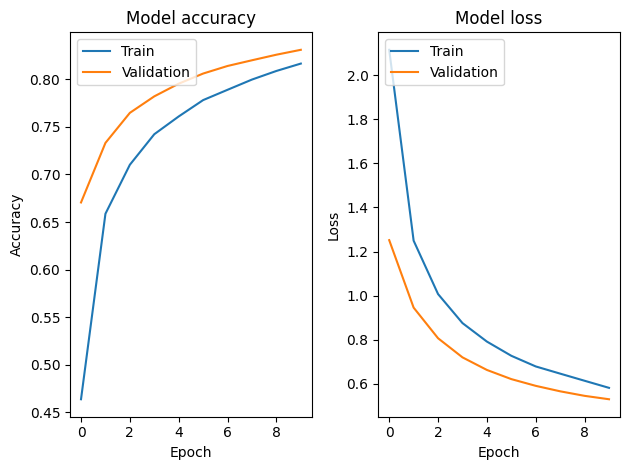

In [53]:
plot_training_metrics(hist)

In [29]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

def load_test(data_path):
    ''' 
    Function needs filepath as parameter, it will create a validation dataset of 20% of the total df, 
    Needs an RSEED as global variable,
    Image will be cropped to 1:1 and altered to 224 x 224
    '''
    image_dataset = tf.keras.utils.image_dataset_from_directory(
        data_path,
        image_size = (224, 224),
        crop_to_aspect_ratio = True,
        label_mode = 'categorical',
        shuffle = False
    )
    return image_dataset 


In [56]:
dataset_test_path = '../data/filtered_diseases/test_filtered/'

test_ds = load_test(dataset_test_path)

Found 17782 files belonging to 26 classes.


In [64]:
'''
# Step 1: Get the true labels from the test dataset
y_true = []
for filepath in test_ds.file_paths:
    label = os.path.basename(os.path.dirname(filepath))
    y_true.append(label)

# Extract unique class labels from your training data
classes = sorted(set(y_true))

# Step 2: Convert true labels to indices using the same mapping used during training
class_to_index = {cls: i for i, cls in enumerate(classes)}
y_true_indices = np.array([class_to_index[label] for label in y_true])

# Step 3: Use your model to make predictions on the test dataset
y_pred_probabilities = patho_model_10.predict(test_ds)
'''
# Step 4: Convert the predicted class probabilities to class labels
y_pred_indices = np.argmax(y_pred_probabilities, axis=1)
y_pred = [classes[i] for i in y_pred_indices]

# Step 5: Generate the classification report
report = classification_report(y_true, y_pred)
print("Classification Report:")
print(report)


Classification Report:
                      precision    recall  f1-score   support

alternaria_leaf_spot       0.98      0.66      0.79       128
    bacterial_blight       0.65      0.45      0.53       584
      bacterial_spot       0.92      0.95      0.94      1157
      bacterial_wilt       0.77      0.50      0.60       113
       black_measles       0.86      0.75      0.80       449
           black_rot       0.96      0.92      0.94       384
               blast       0.74      0.67      0.70       303
          brown_spot       0.80      0.80      0.80       698
brown_streak_disease       0.46      0.37      0.41       451
     citrus_greening       0.99      1.00      1.00      1183
         common_rust       0.91      0.86      0.88       224
        early_blight       0.90      0.80      0.85       656
      gray_leaf_spot       0.73      0.55      0.63        98
        green_mottle       0.27      0.10      0.14       494
             healthy       0.85      0.84     

In [60]:
y_pred_probabilities

array([[2.8365588e-01, 1.8602439e-03, 1.1910431e-03, ..., 2.6136015e-03,
        5.3375289e-03, 4.9232761e-03],
       [2.8365588e-01, 1.8602439e-03, 1.1910431e-03, ..., 2.6136015e-03,
        5.3375289e-03, 4.9232761e-03],
       [4.7323713e-01, 1.8639660e-03, 1.3165810e-03, ..., 3.7086378e-03,
        2.4159062e-03, 4.4597234e-03],
       ...,
       [1.5716272e-04, 3.8082349e-01, 4.3574686e-04, ..., 2.1776333e-03,
        7.2304369e-04, 1.3502304e-01],
       [6.0936005e-04, 2.4794206e-01, 2.6557967e-04, ..., 1.4988283e-03,
        5.9332483e-04, 3.6977628e-01],
       [7.8269775e-04, 8.3355131e-03, 2.6214952e-05, ..., 1.6773554e-05,
        3.3238807e-06, 9.7937268e-01]], dtype=float32)

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 3s 3s/step


  1%|          | 10/1000 [00:03<05:29,  3.00it/s]

1/1 [==============================] - 0s 327ms/step


  2%|▏         | 20/1000 [00:03<02:45,  5.92it/s]

1/1 [==============================] - 0s 388ms/step


  3%|▎         | 30/1000 [00:04<01:49,  8.82it/s]

1/1 [==============================] - 0s 115ms/step


  4%|▍         | 40/1000 [00:06<02:20,  6.85it/s]

1/1 [==============================] - 0s 35ms/step


  5%|▌         | 50/1000 [00:06<01:34, 10.09it/s]

1/1 [==============================] - 0s 48ms/step


  6%|▌         | 60/1000 [00:06<01:06, 14.24it/s]

1/1 [==============================] - 0s 38ms/step


  7%|▋         | 70/1000 [00:06<00:48, 19.23it/s]

1/1 [==============================] - 0s 39ms/step


  8%|▊         | 80/1000 [00:06<00:37, 24.54it/s]

1/1 [==============================] - 0s 36ms/step


  9%|▉         | 90/1000 [00:07<00:29, 31.20it/s]

1/1 [==============================] - 0s 45ms/step


 11%|█         | 108/1000 [00:07<00:20, 42.80it/s]

1/1 [==============================] - 0s 116ms/step


 12%|█▏        | 115/1000 [00:07<00:25, 35.02it/s]

1/1 [==============================] - 0s 179ms/step


 12%|█▏        | 121/1000 [00:07<00:27, 32.15it/s]

1/1 [==============================] - 0s 39ms/step


 13%|█▎        | 130/1000 [00:08<00:23, 37.73it/s]

1/1 [==============================] - 0s 46ms/step


 14%|█▍        | 140/1000 [00:08<00:18, 45.61it/s]

1/1 [==============================] - 0s 38ms/step


 15%|█▌        | 150/1000 [00:08<00:16, 52.55it/s]

1/1 [==============================] - 0s 40ms/step


 16%|█▌        | 160/1000 [00:08<00:14, 58.30it/s]

1/1 [==============================] - 0s 43ms/step


 17%|█▋        | 170/1000 [00:08<00:13, 61.86it/s]

1/1 [==============================] - 0s 36ms/step


 18%|█▊        | 180/1000 [00:08<00:12, 65.18it/s]

1/1 [==============================] - 0s 37ms/step


 19%|█▉        | 190/1000 [00:08<00:11, 67.74it/s]

1/1 [==============================] - 0s 35ms/step


 20%|██        | 200/1000 [00:08<00:11, 70.90it/s]

1/1 [==============================] - 0s 39ms/step


 21%|██        | 210/1000 [00:09<00:10, 72.34it/s]

1/1 [==============================] - 0s 35ms/step


 22%|██▏       | 220/1000 [00:09<00:10, 73.91it/s]

1/1 [==============================] - 0s 35ms/step


 23%|██▎       | 230/1000 [00:09<00:10, 75.64it/s]

1/1 [==============================] - 0s 37ms/step


 24%|██▍       | 240/1000 [00:09<00:10, 75.62it/s]

1/1 [==============================] - 0s 35ms/step


 25%|██▌       | 250/1000 [00:09<00:09, 77.56it/s]

1/1 [==============================] - 0s 35ms/step


 26%|██▌       | 260/1000 [00:09<00:09, 78.67it/s]

1/1 [==============================] - 0s 36ms/step


 27%|██▋       | 270/1000 [00:09<00:09, 79.02it/s]

1/1 [==============================] - 0s 43ms/step


 28%|██▊       | 280/1000 [00:09<00:09, 79.11it/s]

1/1 [==============================] - 0s 37ms/step


 29%|██▉       | 290/1000 [00:10<00:09, 76.76it/s]

1/1 [==============================] - 0s 50ms/step


 30%|███       | 300/1000 [00:10<00:09, 70.60it/s]

1/1 [==============================] - 0s 40ms/step


 31%|███       | 310/1000 [00:10<00:09, 73.24it/s]

1/1 [==============================] - 0s 35ms/step


 32%|███▏      | 320/1000 [00:10<00:08, 75.62it/s]

1/1 [==============================] - 0s 35ms/step


 33%|███▎      | 330/1000 [00:10<00:08, 77.82it/s]

1/1 [==============================] - 0s 35ms/step


 34%|███▍      | 340/1000 [00:10<00:08, 77.98it/s]

1/1 [==============================] - 0s 36ms/step


 35%|███▌      | 350/1000 [00:10<00:08, 78.32it/s]

1/1 [==============================] - 0s 34ms/step


 36%|███▌      | 360/1000 [00:11<00:08, 79.32it/s]

1/1 [==============================] - 0s 35ms/step


 37%|███▋      | 370/1000 [00:11<00:07, 79.48it/s]

1/1 [==============================] - 0s 36ms/step


 38%|███▊      | 380/1000 [00:11<00:07, 80.66it/s]

1/1 [==============================] - 0s 36ms/step


 39%|███▉      | 390/1000 [00:11<00:07, 80.81it/s]

1/1 [==============================] - 0s 36ms/step


 40%|████      | 400/1000 [00:11<00:07, 81.22it/s]

1/1 [==============================] - 0s 36ms/step


 41%|████      | 410/1000 [00:11<00:07, 81.48it/s]

1/1 [==============================] - 0s 36ms/step


 42%|████▏     | 420/1000 [00:11<00:07, 80.80it/s]

1/1 [==============================] - 0s 36ms/step


 43%|████▎     | 430/1000 [00:11<00:07, 80.63it/s]

1/1 [==============================] - 0s 36ms/step


 44%|████▍     | 440/1000 [00:11<00:06, 80.66it/s]

1/1 [==============================] - 0s 37ms/step


 45%|████▌     | 450/1000 [00:12<00:06, 79.57it/s]

1/1 [==============================] - 0s 36ms/step


 46%|████▌     | 460/1000 [00:12<00:06, 79.42it/s]

1/1 [==============================] - 0s 35ms/step


 47%|████▋     | 470/1000 [00:12<00:06, 80.24it/s]

1/1 [==============================] - 0s 36ms/step


 48%|████▊     | 480/1000 [00:12<00:06, 79.64it/s]

1/1 [==============================] - 0s 37ms/step


 49%|████▉     | 490/1000 [00:12<00:06, 80.23it/s]

1/1 [==============================] - 0s 35ms/step


 50%|█████     | 500/1000 [00:12<00:06, 81.11it/s]

1/1 [==============================] - 0s 35ms/step


 51%|█████     | 510/1000 [00:12<00:06, 78.96it/s]

1/1 [==============================] - 0s 35ms/step


 52%|█████▏    | 520/1000 [00:13<00:06, 76.70it/s]

1/1 [==============================] - 0s 35ms/step


 53%|█████▎    | 530/1000 [00:13<00:06, 78.15it/s]

1/1 [==============================] - 0s 35ms/step


 54%|█████▍    | 540/1000 [00:13<00:05, 79.41it/s]

1/1 [==============================] - 0s 37ms/step


 55%|█████▌    | 550/1000 [00:13<00:05, 79.59it/s]

1/1 [==============================] - 0s 37ms/step


 56%|█████▌    | 560/1000 [00:13<00:05, 79.05it/s]

1/1 [==============================] - 0s 35ms/step


 57%|█████▋    | 570/1000 [00:13<00:05, 80.27it/s]

1/1 [==============================] - 0s 35ms/step


 58%|█████▊    | 580/1000 [00:13<00:05, 80.72it/s]

1/1 [==============================] - 0s 37ms/step


 59%|█████▉    | 590/1000 [00:13<00:05, 80.66it/s]

1/1 [==============================] - 0s 34ms/step


 60%|██████    | 600/1000 [00:13<00:04, 81.72it/s]

1/1 [==============================] - 0s 34ms/step


 61%|██████    | 610/1000 [00:14<00:04, 82.07it/s]

1/1 [==============================] - 0s 34ms/step


 62%|██████▏   | 620/1000 [00:14<00:04, 82.22it/s]

1/1 [==============================] - 0s 34ms/step


 63%|██████▎   | 630/1000 [00:14<00:04, 82.48it/s]

1/1 [==============================] - 0s 35ms/step


 64%|██████▍   | 640/1000 [00:14<00:04, 82.46it/s]

1/1 [==============================] - 0s 34ms/step


 65%|██████▌   | 650/1000 [00:14<00:04, 82.39it/s]

1/1 [==============================] - 0s 35ms/step


 66%|██████▌   | 660/1000 [00:14<00:04, 82.30it/s]

1/1 [==============================] - 0s 39ms/step


 67%|██████▋   | 670/1000 [00:14<00:04, 82.03it/s]

1/1 [==============================] - 0s 40ms/step


 68%|██████▊   | 680/1000 [00:14<00:03, 80.71it/s]

1/1 [==============================] - 0s 36ms/step


 69%|██████▉   | 690/1000 [00:15<00:03, 80.84it/s]

1/1 [==============================] - 0s 52ms/step


 70%|███████   | 700/1000 [00:15<00:04, 73.43it/s]

1/1 [==============================] - 0s 36ms/step


 71%|███████   | 710/1000 [00:15<00:03, 75.46it/s]

1/1 [==============================] - 0s 36ms/step


 72%|███████▏  | 720/1000 [00:15<00:03, 76.91it/s]

1/1 [==============================] - 0s 36ms/step


 73%|███████▎  | 730/1000 [00:15<00:03, 77.93it/s]

1/1 [==============================] - 0s 35ms/step


 74%|███████▍  | 740/1000 [00:15<00:03, 77.95it/s]

1/1 [==============================] - 0s 41ms/step


 75%|███████▌  | 750/1000 [00:15<00:03, 77.34it/s]

1/1 [==============================] - 0s 36ms/step


 76%|███████▌  | 760/1000 [00:16<00:03, 78.35it/s]

1/1 [==============================] - 0s 34ms/step


 77%|███████▋  | 770/1000 [00:16<00:02, 79.53it/s]

1/1 [==============================] - 0s 34ms/step


 78%|███████▊  | 780/1000 [00:16<00:02, 80.35it/s]

1/1 [==============================] - 0s 36ms/step


 79%|███████▉  | 790/1000 [00:16<00:02, 79.43it/s]

1/1 [==============================] - 0s 40ms/step


 80%|████████  | 800/1000 [00:16<00:02, 79.02it/s]

1/1 [==============================] - 0s 37ms/step


 81%|████████  | 810/1000 [00:16<00:02, 79.34it/s]

1/1 [==============================] - 0s 35ms/step


 82%|████████▏ | 820/1000 [00:16<00:02, 79.54it/s]

1/1 [==============================] - 0s 35ms/step


 83%|████████▎ | 830/1000 [00:16<00:02, 80.02it/s]

1/1 [==============================] - 0s 35ms/step


 84%|████████▍ | 840/1000 [00:17<00:01, 80.52it/s]

1/1 [==============================] - 0s 34ms/step


 85%|████████▌ | 850/1000 [00:17<00:01, 81.41it/s]

1/1 [==============================] - 0s 37ms/step


 86%|████████▌ | 860/1000 [00:17<00:01, 81.70it/s]

1/1 [==============================] - 0s 37ms/step


 87%|████████▋ | 870/1000 [00:17<00:01, 81.33it/s]

1/1 [==============================] - 0s 53ms/step


 88%|████████▊ | 880/1000 [00:17<00:01, 75.60it/s]

1/1 [==============================] - 0s 35ms/step


 89%|████████▉ | 890/1000 [00:17<00:01, 77.72it/s]

1/1 [==============================] - 0s 38ms/step


 90%|█████████ | 900/1000 [00:17<00:01, 77.30it/s]

1/1 [==============================] - 0s 37ms/step


 91%|█████████ | 910/1000 [00:17<00:01, 76.66it/s]

1/1 [==============================] - 0s 35ms/step


 92%|█████████▏| 920/1000 [00:18<00:01, 75.51it/s]

1/1 [==============================] - 0s 36ms/step


 93%|█████████▎| 930/1000 [00:18<00:00, 77.33it/s]

1/1 [==============================] - 0s 35ms/step


 94%|█████████▍| 940/1000 [00:18<00:00, 78.75it/s]

1/1 [==============================] - 0s 33ms/step


 95%|█████████▌| 950/1000 [00:18<00:00, 79.77it/s]

1/1 [==============================] - 0s 33ms/step


 96%|█████████▌| 960/1000 [00:18<00:00, 80.89it/s]

1/1 [==============================] - 0s 35ms/step


 97%|█████████▋| 970/1000 [00:18<00:00, 80.48it/s]

1/1 [==============================] - 0s 37ms/step


 98%|█████████▊| 980/1000 [00:18<00:00, 80.66it/s]

1/1 [==============================] - 0s 35ms/step


 99%|█████████▉| 990/1000 [00:18<00:00, 80.60it/s]

1/1 [==============================] - 0s 35ms/step


100%|██████████| 1000/1000 [00:19<00:00, 52.53it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


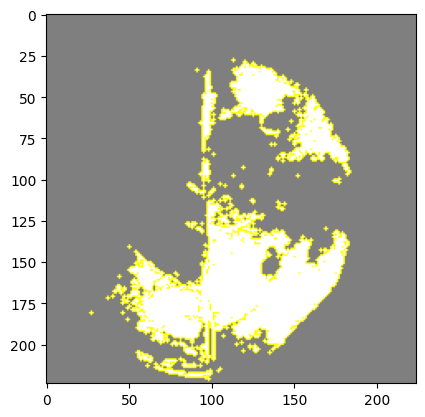

In [65]:
import lime
import tensorflow as tf
from tensorflow import keras
from lime import lime_image
from skimage.segmentation import mark_boundaries
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import preprocess_input
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt


def load_and_preprocess_image(image_path):
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return img_array
def display_original_and_explanation(image_path, model, num_features=5, num_samples=1000):
    # Load and preprocess the original image
    original_image = load_and_preprocess_image(image_path)
    # Create a LIME explainer
    explainer = lime_image.LimeImageExplainer()
    # Generate explanation for the model's prediction
    explanation = explainer.explain_instance(original_image[0].astype('double'), model.predict, top_labels=1, hide_color=0, num_samples=num_samples)
    # Get the visualized explanation
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=num_features, hide_rest=True)
    plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

    

# Path to image file
image_path = '../data/filtered_diseases/test_filtered/alternaria_leaf_spot/000424.out.jpg'
display_original_and_explanation(image_path, patho_model_6)



  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 132ms/step


  1%|          | 10/1000 [00:00<00:30, 32.84it/s]

1/1 [==============================] - 0s 42ms/step


  2%|▏         | 20/1000 [00:00<00:21, 45.88it/s]

1/1 [==============================] - 0s 38ms/step


  3%|▎         | 30/1000 [00:00<00:17, 55.13it/s]

1/1 [==============================] - 0s 36ms/step


  4%|▍         | 40/1000 [00:00<00:15, 62.18it/s]

1/1 [==============================] - 0s 37ms/step


  5%|▌         | 50/1000 [00:00<00:14, 66.89it/s]

1/1 [==============================] - 0s 66ms/step


  6%|▌         | 60/1000 [00:01<00:15, 60.68it/s]

1/1 [==============================] - 0s 40ms/step


  7%|▋         | 70/1000 [00:01<00:15, 58.60it/s]

1/1 [==============================] - 0s 35ms/step


  8%|▊         | 80/1000 [00:01<00:14, 62.43it/s]

1/1 [==============================] - 0s 39ms/step


  9%|▉         | 90/1000 [00:01<00:14, 63.36it/s]

1/1 [==============================] - 0s 62ms/step


 10%|█         | 100/1000 [00:01<00:14, 62.08it/s]

1/1 [==============================] - 0s 41ms/step


 11%|█         | 110/1000 [00:01<00:13, 65.95it/s]

1/1 [==============================] - 0s 81ms/step


 12%|█▏        | 120/1000 [00:02<00:14, 60.92it/s]

1/1 [==============================] - 0s 48ms/step


 13%|█▎        | 130/1000 [00:02<00:14, 61.39it/s]

1/1 [==============================] - 0s 39ms/step


 14%|█▍        | 140/1000 [00:02<00:14, 61.16it/s]

1/1 [==============================] - 0s 38ms/step


 15%|█▌        | 150/1000 [00:02<00:14, 57.47it/s]

1/1 [==============================] - 0s 34ms/step


 16%|█▌        | 160/1000 [00:02<00:13, 63.03it/s]

1/1 [==============================] - 0s 34ms/step


 17%|█▋        | 170/1000 [00:02<00:12, 67.61it/s]

1/1 [==============================] - 0s 35ms/step


 18%|█▊        | 180/1000 [00:02<00:11, 71.42it/s]

1/1 [==============================] - 0s 39ms/step


 19%|█▉        | 190/1000 [00:03<00:11, 71.82it/s]

1/1 [==============================] - 0s 36ms/step


 20%|██        | 200/1000 [00:03<00:10, 74.49it/s]

1/1 [==============================] - 0s 34ms/step


 21%|██        | 210/1000 [00:03<00:10, 76.67it/s]

1/1 [==============================] - 0s 34ms/step


 22%|██▏       | 220/1000 [00:03<00:09, 78.28it/s]

1/1 [==============================] - 0s 34ms/step


 23%|██▎       | 230/1000 [00:03<00:09, 79.06it/s]

1/1 [==============================] - 0s 35ms/step


 24%|██▍       | 240/1000 [00:03<00:09, 80.15it/s]

1/1 [==============================] - 0s 36ms/step


 25%|██▌       | 250/1000 [00:03<00:09, 80.63it/s]

1/1 [==============================] - 0s 34ms/step


 26%|██▌       | 260/1000 [00:03<00:09, 80.96it/s]

1/1 [==============================] - 0s 34ms/step


 27%|██▋       | 270/1000 [00:04<00:08, 81.51it/s]

1/1 [==============================] - 0s 35ms/step


 28%|██▊       | 280/1000 [00:04<00:08, 81.67it/s]

1/1 [==============================] - 0s 35ms/step


 29%|██▉       | 290/1000 [00:04<00:08, 82.03it/s]

1/1 [==============================] - 0s 34ms/step


 30%|███       | 300/1000 [00:04<00:08, 79.33it/s]

1/1 [==============================] - 0s 40ms/step


 31%|███       | 310/1000 [00:04<00:09, 76.64it/s]

1/1 [==============================] - 0s 34ms/step


 32%|███▏      | 320/1000 [00:04<00:08, 78.32it/s]

1/1 [==============================] - 0s 43ms/step


 33%|███▎      | 330/1000 [00:04<00:08, 76.22it/s]

1/1 [==============================] - 0s 35ms/step


 34%|███▍      | 340/1000 [00:04<00:08, 78.32it/s]

1/1 [==============================] - 0s 34ms/step


 35%|███▌      | 350/1000 [00:05<00:08, 79.71it/s]

1/1 [==============================] - 0s 35ms/step


 36%|███▌      | 360/1000 [00:05<00:07, 80.57it/s]

1/1 [==============================] - 0s 35ms/step


 37%|███▋      | 370/1000 [00:05<00:07, 81.12it/s]

1/1 [==============================] - 0s 35ms/step


 38%|███▊      | 380/1000 [00:05<00:07, 81.49it/s]

1/1 [==============================] - 0s 35ms/step


 39%|███▉      | 390/1000 [00:05<00:07, 81.32it/s]

1/1 [==============================] - 0s 35ms/step


 40%|████      | 400/1000 [00:05<00:07, 81.31it/s]

1/1 [==============================] - 0s 35ms/step


 41%|████      | 410/1000 [00:05<00:07, 81.54it/s]

1/1 [==============================] - 0s 34ms/step


 42%|████▏     | 420/1000 [00:05<00:07, 81.66it/s]

1/1 [==============================] - 0s 34ms/step


 43%|████▎     | 430/1000 [00:06<00:06, 82.12it/s]

1/1 [==============================] - 0s 34ms/step


 44%|████▍     | 440/1000 [00:06<00:06, 81.95it/s]

1/1 [==============================] - 0s 34ms/step


 45%|████▌     | 450/1000 [00:06<00:06, 82.09it/s]

1/1 [==============================] - 0s 35ms/step


 46%|████▌     | 460/1000 [00:06<00:06, 82.53it/s]

1/1 [==============================] - 0s 35ms/step


 47%|████▋     | 470/1000 [00:06<00:06, 82.24it/s]

1/1 [==============================] - 0s 34ms/step


 48%|████▊     | 480/1000 [00:06<00:06, 82.24it/s]

1/1 [==============================] - 0s 45ms/step


 49%|████▉     | 490/1000 [00:06<00:06, 76.91it/s]

1/1 [==============================] - 0s 34ms/step


 50%|█████     | 500/1000 [00:06<00:06, 78.76it/s]

1/1 [==============================] - 0s 34ms/step


 51%|█████     | 510/1000 [00:07<00:06, 79.96it/s]

1/1 [==============================] - 0s 34ms/step


 52%|█████▏    | 520/1000 [00:07<00:05, 80.89it/s]

1/1 [==============================] - 0s 35ms/step


 53%|█████▎    | 530/1000 [00:07<00:05, 79.87it/s]

1/1 [==============================] - 0s 38ms/step


 54%|█████▍    | 540/1000 [00:07<00:05, 80.19it/s]

1/1 [==============================] - 0s 34ms/step


 55%|█████▌    | 550/1000 [00:07<00:05, 81.20it/s]

1/1 [==============================] - 0s 34ms/step


 56%|█████▌    | 560/1000 [00:07<00:05, 81.77it/s]

1/1 [==============================] - 0s 34ms/step


 57%|█████▋    | 570/1000 [00:07<00:05, 82.40it/s]

1/1 [==============================] - 0s 34ms/step


 58%|█████▊    | 580/1000 [00:07<00:05, 82.76it/s]

1/1 [==============================] - 0s 35ms/step


 59%|█████▉    | 590/1000 [00:07<00:04, 83.05it/s]

1/1 [==============================] - 0s 34ms/step


 60%|██████    | 600/1000 [00:08<00:04, 83.44it/s]

1/1 [==============================] - 0s 33ms/step


 61%|██████    | 610/1000 [00:08<00:04, 84.10it/s]

1/1 [==============================] - 0s 34ms/step


 62%|██████▏   | 620/1000 [00:08<00:04, 83.58it/s]

1/1 [==============================] - 0s 36ms/step


 63%|██████▎   | 630/1000 [00:08<00:04, 81.18it/s]

1/1 [==============================] - 0s 34ms/step


 64%|██████▍   | 640/1000 [00:08<00:04, 79.58it/s]

1/1 [==============================] - 0s 39ms/step


 65%|██████▌   | 650/1000 [00:08<00:04, 78.21it/s]

1/1 [==============================] - 0s 38ms/step


 66%|██████▌   | 660/1000 [00:08<00:04, 78.16it/s]

1/1 [==============================] - 0s 37ms/step


 67%|██████▋   | 670/1000 [00:08<00:04, 78.84it/s]

1/1 [==============================] - 0s 35ms/step


 68%|██████▊   | 680/1000 [00:09<00:04, 79.46it/s]

1/1 [==============================] - 0s 35ms/step


 69%|██████▉   | 690/1000 [00:09<00:03, 79.92it/s]

1/1 [==============================] - 0s 38ms/step


 70%|███████   | 700/1000 [00:09<00:03, 79.68it/s]

1/1 [==============================] - 0s 36ms/step


 71%|███████   | 710/1000 [00:09<00:03, 79.47it/s]

1/1 [==============================] - 0s 36ms/step


 72%|███████▏  | 720/1000 [00:09<00:03, 79.87it/s]

1/1 [==============================] - 0s 34ms/step


 73%|███████▎  | 730/1000 [00:09<00:03, 80.74it/s]

1/1 [==============================] - 0s 35ms/step


 74%|███████▍  | 740/1000 [00:09<00:03, 81.21it/s]

1/1 [==============================] - 0s 33ms/step


 75%|███████▌  | 750/1000 [00:09<00:03, 81.81it/s]

1/1 [==============================] - 0s 37ms/step


 76%|███████▌  | 760/1000 [00:10<00:02, 81.08it/s]

1/1 [==============================] - 0s 34ms/step


 77%|███████▋  | 770/1000 [00:10<00:02, 79.39it/s]

1/1 [==============================] - 0s 35ms/step


 78%|███████▊  | 780/1000 [00:10<00:02, 78.25it/s]

1/1 [==============================] - 0s 34ms/step


 79%|███████▉  | 790/1000 [00:10<00:02, 79.27it/s]

1/1 [==============================] - 0s 35ms/step


 80%|████████  | 800/1000 [00:10<00:02, 80.22it/s]

1/1 [==============================] - 0s 35ms/step


 81%|████████  | 810/1000 [00:10<00:02, 80.96it/s]

1/1 [==============================] - 0s 34ms/step


 82%|████████▏ | 820/1000 [00:10<00:02, 81.38it/s]

1/1 [==============================] - 0s 33ms/step


 83%|████████▎ | 830/1000 [00:10<00:02, 82.41it/s]

1/1 [==============================] - 0s 33ms/step


 84%|████████▍ | 840/1000 [00:11<00:01, 82.57it/s]

1/1 [==============================] - 0s 34ms/step


 85%|████████▌ | 850/1000 [00:11<00:01, 82.72it/s]

1/1 [==============================] - 0s 34ms/step


 86%|████████▌ | 860/1000 [00:11<00:01, 82.11it/s]

1/1 [==============================] - 0s 34ms/step


 87%|████████▋ | 870/1000 [00:11<00:01, 82.54it/s]

1/1 [==============================] - 0s 35ms/step


 88%|████████▊ | 880/1000 [00:11<00:01, 81.30it/s]

1/1 [==============================] - 0s 36ms/step


 89%|████████▉ | 890/1000 [00:11<00:01, 81.48it/s]

1/1 [==============================] - 0s 34ms/step


 90%|█████████ | 900/1000 [00:11<00:01, 82.13it/s]

1/1 [==============================] - 0s 34ms/step


 91%|█████████ | 910/1000 [00:11<00:01, 82.31it/s]

1/1 [==============================] - 0s 35ms/step


 92%|█████████▏| 920/1000 [00:12<00:00, 80.39it/s]

1/1 [==============================] - 0s 33ms/step


 93%|█████████▎| 930/1000 [00:12<00:00, 78.58it/s]

1/1 [==============================] - 0s 33ms/step


 94%|█████████▍| 940/1000 [00:12<00:00, 79.29it/s]

1/1 [==============================] - 0s 33ms/step


 95%|█████████▌| 950/1000 [00:12<00:00, 80.39it/s]

1/1 [==============================] - 0s 33ms/step


 96%|█████████▌| 960/1000 [00:12<00:00, 81.23it/s]

1/1 [==============================] - 0s 34ms/step


 97%|█████████▋| 970/1000 [00:12<00:00, 81.72it/s]

1/1 [==============================] - 0s 34ms/step


 98%|█████████▊| 980/1000 [00:12<00:00, 81.95it/s]

1/1 [==============================] - 0s 35ms/step


 99%|█████████▉| 990/1000 [00:12<00:00, 80.71it/s]

1/1 [==============================] - 0s 34ms/step


100%|██████████| 1000/1000 [00:13<00:00, 76.54it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


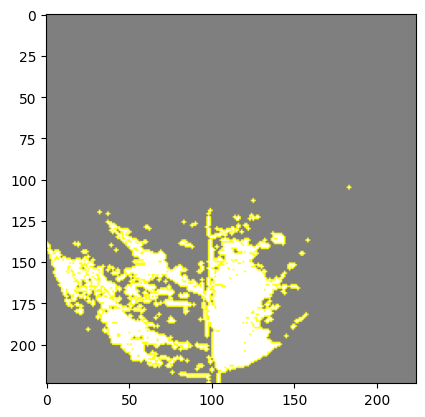

In [34]:

# Path to image file
image_path = '../data/test/alternaria_leaf_spot/000424.jpg'
display_original_and_explanation(image_path, patho_model_6)

In [66]:
import os
import keras
from keras.applications import inception_v3 as inc_net
from keras.preprocessing import image
from keras.applications.imagenet_utils import decode_predictions
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sys
import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries
# set IMAGE and MODEL global variables


1/1 [==============================] - 4s 4s/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 76ms/step


  1%|          | 10/1000 [00:00<00:26, 38.02it/s]

1/1 [==============================] - 0s 35ms/step


  2%|▏         | 20/1000 [00:00<00:17, 55.52it/s]

1/1 [==============================] - 0s 35ms/step


  3%|▎         | 30/1000 [00:00<00:14, 65.85it/s]

1/1 [==============================] - 0s 36ms/step


  4%|▍         | 40/1000 [00:00<00:13, 72.12it/s]

1/1 [==============================] - 0s 36ms/step


  5%|▌         | 50/1000 [00:00<00:12, 75.98it/s]

1/1 [==============================] - 0s 35ms/step


  6%|▌         | 60/1000 [00:00<00:11, 78.53it/s]

1/1 [==============================] - 0s 35ms/step


  7%|▋         | 70/1000 [00:00<00:11, 80.52it/s]

1/1 [==============================] - 0s 36ms/step


  8%|▊         | 80/1000 [00:01<00:11, 80.06it/s]

1/1 [==============================] - 0s 35ms/step


  9%|▉         | 90/1000 [00:01<00:11, 81.78it/s]

1/1 [==============================] - 0s 39ms/step


 10%|█         | 100/1000 [00:01<00:10, 82.25it/s]

1/1 [==============================] - 0s 46ms/step


 11%|█         | 110/1000 [00:01<00:12, 71.57it/s]

1/1 [==============================] - 0s 36ms/step


 12%|█▏        | 120/1000 [00:01<00:11, 75.35it/s]

1/1 [==============================] - 0s 36ms/step


 13%|█▎        | 130/1000 [00:01<00:11, 76.78it/s]

1/1 [==============================] - 0s 36ms/step


 14%|█▍        | 140/1000 [00:01<00:10, 79.41it/s]

1/1 [==============================] - 0s 34ms/step


 15%|█▌        | 150/1000 [00:01<00:10, 81.52it/s]

1/1 [==============================] - 0s 38ms/step


 16%|█▌        | 160/1000 [00:02<00:10, 80.89it/s]

1/1 [==============================] - 0s 36ms/step


 17%|█▋        | 170/1000 [00:02<00:10, 82.83it/s]

1/1 [==============================] - 0s 35ms/step


 18%|█▊        | 180/1000 [00:02<00:09, 83.81it/s]

1/1 [==============================] - 0s 35ms/step


 19%|█▉        | 190/1000 [00:02<00:09, 84.33it/s]

1/1 [==============================] - 0s 34ms/step


 20%|██        | 200/1000 [00:02<00:09, 85.29it/s]

1/1 [==============================] - 0s 36ms/step


 21%|██        | 210/1000 [00:02<00:09, 84.89it/s]

1/1 [==============================] - 0s 36ms/step


 22%|██▏       | 220/1000 [00:02<00:09, 84.14it/s]

1/1 [==============================] - 0s 37ms/step


 23%|██▎       | 230/1000 [00:02<00:09, 84.45it/s]

1/1 [==============================] - 0s 36ms/step


 24%|██▍       | 240/1000 [00:03<00:08, 84.88it/s]

1/1 [==============================] - 0s 36ms/step


 25%|██▌       | 250/1000 [00:03<00:08, 85.21it/s]

1/1 [==============================] - 0s 36ms/step


 26%|██▌       | 260/1000 [00:03<00:08, 85.26it/s]

1/1 [==============================] - 0s 53ms/step


 27%|██▋       | 270/1000 [00:03<00:09, 80.08it/s]

1/1 [==============================] - 0s 35ms/step


 28%|██▊       | 280/1000 [00:03<00:08, 81.76it/s]

1/1 [==============================] - 0s 35ms/step


 29%|██▉       | 290/1000 [00:03<00:08, 82.83it/s]

1/1 [==============================] - 0s 35ms/step


 30%|███       | 300/1000 [00:03<00:08, 83.65it/s]

1/1 [==============================] - 0s 35ms/step


 31%|███       | 310/1000 [00:03<00:08, 84.52it/s]

1/1 [==============================] - 0s 35ms/step


 32%|███▏      | 320/1000 [00:04<00:07, 85.22it/s]

1/1 [==============================] - 0s 38ms/step


 33%|███▎      | 330/1000 [00:04<00:07, 84.98it/s]

1/1 [==============================] - 0s 35ms/step


 34%|███▍      | 340/1000 [00:04<00:07, 84.27it/s]

1/1 [==============================] - 0s 36ms/step


 35%|███▌      | 350/1000 [00:04<00:07, 84.43it/s]

1/1 [==============================] - 0s 35ms/step


 36%|███▌      | 360/1000 [00:04<00:07, 85.36it/s]

1/1 [==============================] - 0s 37ms/step


 37%|███▋      | 370/1000 [00:04<00:07, 85.74it/s]

1/1 [==============================] - 0s 35ms/step


 38%|███▊      | 380/1000 [00:04<00:07, 85.84it/s]

1/1 [==============================] - 0s 36ms/step


 39%|███▉      | 390/1000 [00:04<00:07, 85.73it/s]

1/1 [==============================] - 0s 36ms/step


 40%|████      | 400/1000 [00:04<00:06, 85.81it/s]

1/1 [==============================] - 0s 34ms/step


 41%|████      | 410/1000 [00:05<00:06, 86.07it/s]

1/1 [==============================] - 0s 35ms/step


 42%|████▏     | 420/1000 [00:05<00:06, 83.59it/s]

1/1 [==============================] - 0s 36ms/step


 43%|████▎     | 430/1000 [00:05<00:06, 81.83it/s]

1/1 [==============================] - 0s 35ms/step


 44%|████▍     | 440/1000 [00:05<00:06, 83.26it/s]

1/1 [==============================] - 0s 36ms/step


 45%|████▌     | 450/1000 [00:05<00:06, 83.17it/s]

1/1 [==============================] - 0s 34ms/step


 46%|████▌     | 460/1000 [00:05<00:06, 83.98it/s]

1/1 [==============================] - 0s 34ms/step


 47%|████▋     | 470/1000 [00:05<00:06, 85.00it/s]

1/1 [==============================] - 0s 35ms/step


 48%|████▊     | 480/1000 [00:05<00:06, 85.47it/s]

1/1 [==============================] - 0s 37ms/step


 49%|████▉     | 490/1000 [00:06<00:05, 85.04it/s]

1/1 [==============================] - 0s 35ms/step


 50%|█████     | 500/1000 [00:06<00:05, 85.57it/s]

1/1 [==============================] - 0s 36ms/step


 51%|█████     | 510/1000 [00:06<00:05, 85.59it/s]

1/1 [==============================] - 0s 34ms/step


 52%|█████▏    | 520/1000 [00:06<00:05, 86.01it/s]

1/1 [==============================] - 0s 36ms/step


 53%|█████▎    | 530/1000 [00:06<00:05, 86.07it/s]

1/1 [==============================] - 0s 37ms/step


 54%|█████▍    | 540/1000 [00:06<00:05, 85.87it/s]

1/1 [==============================] - 0s 35ms/step


 55%|█████▌    | 550/1000 [00:06<00:05, 85.99it/s]

1/1 [==============================] - 0s 55ms/step


 56%|█████▌    | 560/1000 [00:06<00:05, 80.62it/s]

1/1 [==============================] - 0s 38ms/step


 57%|█████▋    | 570/1000 [00:06<00:05, 80.93it/s]

1/1 [==============================] - 0s 36ms/step


 58%|█████▊    | 580/1000 [00:07<00:05, 82.52it/s]

1/1 [==============================] - 0s 35ms/step


 59%|█████▉    | 590/1000 [00:07<00:04, 83.75it/s]

1/1 [==============================] - 0s 35ms/step


 60%|██████    | 600/1000 [00:07<00:04, 84.73it/s]

1/1 [==============================] - 0s 34ms/step


 61%|██████    | 610/1000 [00:07<00:04, 85.48it/s]

1/1 [==============================] - 0s 35ms/step


 62%|██████▏   | 620/1000 [00:07<00:04, 85.98it/s]

1/1 [==============================] - 0s 35ms/step


 63%|██████▎   | 630/1000 [00:07<00:04, 85.65it/s]

1/1 [==============================] - 0s 35ms/step


 64%|██████▍   | 640/1000 [00:07<00:04, 86.20it/s]

1/1 [==============================] - 0s 35ms/step


 65%|██████▌   | 650/1000 [00:07<00:04, 86.30it/s]

1/1 [==============================] - 0s 35ms/step


 66%|██████▌   | 660/1000 [00:08<00:03, 86.44it/s]

1/1 [==============================] - 0s 35ms/step


 67%|██████▋   | 670/1000 [00:08<00:03, 86.46it/s]

1/1 [==============================] - 0s 35ms/step


 68%|██████▊   | 680/1000 [00:08<00:03, 85.36it/s]

1/1 [==============================] - 0s 35ms/step


 69%|██████▉   | 690/1000 [00:08<00:03, 85.56it/s]

1/1 [==============================] - 0s 37ms/step


 70%|███████   | 700/1000 [00:08<00:03, 84.42it/s]

1/1 [==============================] - 0s 38ms/step


 71%|███████   | 710/1000 [00:08<00:03, 81.21it/s]

1/1 [==============================] - 0s 35ms/step


 72%|███████▏  | 720/1000 [00:08<00:03, 82.73it/s]

1/1 [==============================] - 0s 35ms/step


 73%|███████▎  | 730/1000 [00:08<00:03, 84.22it/s]

1/1 [==============================] - 0s 35ms/step


 74%|███████▍  | 740/1000 [00:08<00:03, 84.79it/s]

1/1 [==============================] - 0s 36ms/step


 75%|███████▌  | 750/1000 [00:09<00:02, 85.24it/s]

1/1 [==============================] - 0s 36ms/step


 76%|███████▌  | 760/1000 [00:09<00:02, 85.70it/s]

1/1 [==============================] - 0s 35ms/step


 77%|███████▋  | 770/1000 [00:09<00:02, 86.13it/s]

1/1 [==============================] - 0s 36ms/step


 78%|███████▊  | 780/1000 [00:09<00:02, 86.03it/s]

1/1 [==============================] - 0s 36ms/step


 79%|███████▉  | 790/1000 [00:09<00:02, 85.63it/s]

1/1 [==============================] - 0s 35ms/step


 80%|████████  | 800/1000 [00:09<00:02, 85.08it/s]

1/1 [==============================] - 0s 35ms/step


 81%|████████  | 810/1000 [00:09<00:02, 85.56it/s]

1/1 [==============================] - 0s 35ms/step


 82%|████████▏ | 820/1000 [00:09<00:02, 85.81it/s]

1/1 [==============================] - 0s 35ms/step


 83%|████████▎ | 830/1000 [00:10<00:01, 86.17it/s]

1/1 [==============================] - 0s 35ms/step


 84%|████████▍ | 840/1000 [00:10<00:01, 86.38it/s]

1/1 [==============================] - 0s 35ms/step


 85%|████████▌ | 850/1000 [00:10<00:01, 84.85it/s]

1/1 [==============================] - 0s 35ms/step


 86%|████████▌ | 860/1000 [00:10<00:01, 82.45it/s]

1/1 [==============================] - 0s 35ms/step


 87%|████████▋ | 870/1000 [00:10<00:01, 83.46it/s]

1/1 [==============================] - 0s 35ms/step


 88%|████████▊ | 880/1000 [00:10<00:01, 84.20it/s]

1/1 [==============================] - 0s 40ms/step


 89%|████████▉ | 890/1000 [00:10<00:01, 77.35it/s]

1/1 [==============================] - 0s 35ms/step


 90%|█████████ | 900/1000 [00:10<00:01, 80.14it/s]

1/1 [==============================] - 0s 35ms/step


 91%|█████████ | 910/1000 [00:11<00:01, 80.88it/s]

1/1 [==============================] - 0s 34ms/step


 92%|█████████▏| 920/1000 [00:11<00:00, 82.86it/s]

1/1 [==============================] - 0s 35ms/step


 93%|█████████▎| 930/1000 [00:11<00:00, 83.78it/s]

1/1 [==============================] - 0s 35ms/step


 94%|█████████▍| 940/1000 [00:11<00:00, 84.38it/s]

1/1 [==============================] - 0s 35ms/step


 95%|█████████▌| 950/1000 [00:11<00:00, 84.54it/s]

1/1 [==============================] - 0s 35ms/step


 96%|█████████▌| 960/1000 [00:11<00:00, 85.15it/s]

1/1 [==============================] - 0s 34ms/step


 97%|█████████▋| 970/1000 [00:11<00:00, 85.45it/s]

1/1 [==============================] - 0s 35ms/step


 98%|█████████▊| 980/1000 [00:11<00:00, 85.94it/s]

1/1 [==============================] - 0s 35ms/step


 99%|█████████▉| 990/1000 [00:11<00:00, 86.27it/s]

1/1 [==============================] - 0s 35ms/step


100%|██████████| 1000/1000 [00:12<00:00, 82.99it/s]


1/1 [==============================] - 0s 128ms/step


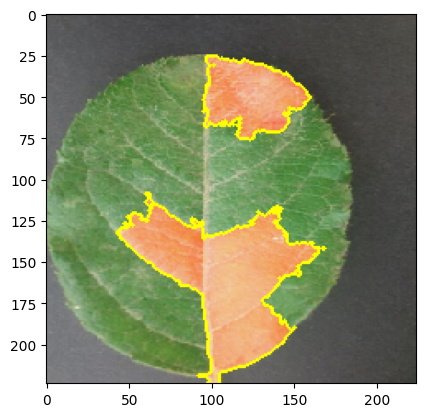

In [37]:

IMAGE = '../data/test/alternaria_leaf_spot/000424.jpg'
MODEL = patho_model_6 
def transform_img_fn(path_list):
    out = []
    for img_path in path_list:
        img = image.load_img(img_path, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = inc_net.preprocess_input(x)
        out.append(x)
    return np.vstack(out) 


images = transform_img_fn([os.path.join(IMAGE)])
preds = MODEL.predict(images) 
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(images[0].astype('double'), MODEL.predict, top_labels=5, hide_color=0, num_samples=1000)
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=4, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=4, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
images = transform_img_fn([os.path.join(IMAGE)])
preds = MODEL.predict(images) 


In [67]:
# for jokes:

import lime
import tensorflow as tf
from tensorflow import keras
from lime import lime_image
from skimage.segmentation import mark_boundaries
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import preprocess_input
import numpy as np
import matplotlib.pyplot as plt

def load_and_preprocess_image(image_path):
    """
    Load and preprocess an image from the given path.
    """
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return img_array

def display_original_and_explanation(image_path, model, num_features=5, num_samples=1000):
    """
    Display the original image and its explanation generated by LIME.
    """
    # Load and preprocess the original image
    original_image = load_and_preprocess_image(image_path)
    
    # Create a LIME explainer
    explainer = lime_image.LimeImageExplainer()
    
    # Generate explanation for the model's prediction
    explanation = explainer.explain_instance(original_image[0].astype('double'), model.predict, top_labels=1, hide_color=0, num_samples=num_samples)
    
    # Get the visualized explanation
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=num_features, hide_rest=True)
    
    # Plot the original image with explanation
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(original_image[0] / 255.0)
    plt.title('Original Image')
    
    plt.subplot(1, 2, 2)
    plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
    plt.title('Explanation')
    plt.show()




  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 4s 4s/step


  1%|          | 10/1000 [00:03<06:06,  2.70it/s]

1/1 [==============================] - 0s 98ms/step


  2%|▏         | 20/1000 [00:03<02:46,  5.90it/s]

1/1 [==============================] - 0s 38ms/step


  3%|▎         | 30/1000 [00:04<01:35, 10.17it/s]

1/1 [==============================] - 0s 230ms/step


  4%|▍         | 40/1000 [00:04<01:07, 14.13it/s]

1/1 [==============================] - 0s 323ms/step


  5%|▌         | 50/1000 [00:04<00:56, 16.95it/s]

1/1 [==============================] - 0s 40ms/step


  6%|▌         | 60/1000 [00:04<00:41, 22.90it/s]

1/1 [==============================] - 0s 35ms/step


  7%|▋         | 70/1000 [00:05<00:31, 29.79it/s]

1/1 [==============================] - 0s 35ms/step


  8%|▊         | 80/1000 [00:05<00:24, 37.09it/s]

1/1 [==============================] - 0s 36ms/step


  9%|▉         | 90/1000 [00:05<00:20, 44.69it/s]

1/1 [==============================] - 0s 35ms/step


 10%|█         | 100/1000 [00:05<00:17, 51.55it/s]

1/1 [==============================] - 0s 35ms/step


 11%|█         | 110/1000 [00:05<00:15, 57.72it/s]

1/1 [==============================] - 0s 38ms/step


 12%|█▏        | 120/1000 [00:05<00:14, 62.68it/s]

1/1 [==============================] - 0s 36ms/step


 13%|█▎        | 130/1000 [00:05<00:13, 66.89it/s]

1/1 [==============================] - 0s 34ms/step


 14%|█▍        | 140/1000 [00:05<00:12, 70.88it/s]

1/1 [==============================] - 0s 34ms/step


 15%|█▌        | 150/1000 [00:06<00:11, 73.78it/s]

1/1 [==============================] - 0s 35ms/step


 16%|█▌        | 160/1000 [00:06<00:11, 74.89it/s]

1/1 [==============================] - 0s 35ms/step


 17%|█▋        | 170/1000 [00:06<00:10, 76.27it/s]

1/1 [==============================] - 0s 38ms/step


 18%|█▊        | 180/1000 [00:06<00:10, 76.61it/s]

1/1 [==============================] - 0s 35ms/step


 19%|█▉        | 190/1000 [00:06<00:10, 77.78it/s]

1/1 [==============================] - 0s 53ms/step


 20%|██        | 200/1000 [00:06<00:11, 67.48it/s]

1/1 [==============================] - 0s 36ms/step


 21%|██        | 210/1000 [00:06<00:11, 70.52it/s]

1/1 [==============================] - 0s 35ms/step


 22%|██▏       | 220/1000 [00:07<00:10, 73.51it/s]

1/1 [==============================] - 0s 35ms/step


 23%|██▎       | 230/1000 [00:07<00:10, 75.77it/s]

1/1 [==============================] - 0s 40ms/step


 24%|██▍       | 240/1000 [00:07<00:09, 76.56it/s]

1/1 [==============================] - 0s 35ms/step


 25%|██▌       | 250/1000 [00:07<00:09, 78.05it/s]

1/1 [==============================] - 0s 37ms/step


 26%|██▌       | 260/1000 [00:07<00:09, 78.10it/s]

1/1 [==============================] - 0s 34ms/step


 27%|██▋       | 270/1000 [00:07<00:09, 79.26it/s]

1/1 [==============================] - 0s 36ms/step


 28%|██▊       | 280/1000 [00:07<00:09, 79.40it/s]

1/1 [==============================] - 0s 35ms/step


 29%|██▉       | 290/1000 [00:07<00:08, 79.25it/s]

1/1 [==============================] - 0s 37ms/step


 30%|███       | 300/1000 [00:08<00:08, 80.05it/s]

1/1 [==============================] - 0s 34ms/step


 31%|███       | 310/1000 [00:08<00:08, 80.03it/s]

1/1 [==============================] - 0s 34ms/step


 32%|███▏      | 320/1000 [00:08<00:08, 81.03it/s]

1/1 [==============================] - 0s 38ms/step


 33%|███▎      | 330/1000 [00:08<00:08, 80.41it/s]

1/1 [==============================] - 0s 35ms/step


 34%|███▍      | 340/1000 [00:08<00:08, 81.12it/s]

1/1 [==============================] - 0s 34ms/step


 35%|███▌      | 350/1000 [00:08<00:08, 81.03it/s]

1/1 [==============================] - 0s 35ms/step


 36%|███▌      | 360/1000 [00:08<00:07, 81.49it/s]

1/1 [==============================] - 0s 33ms/step


 37%|███▋      | 370/1000 [00:08<00:07, 82.58it/s]

1/1 [==============================] - 0s 34ms/step


 38%|███▊      | 380/1000 [00:08<00:07, 82.31it/s]

1/1 [==============================] - 0s 34ms/step


 39%|███▉      | 390/1000 [00:09<00:07, 81.94it/s]

1/1 [==============================] - 0s 41ms/step


 40%|████      | 400/1000 [00:09<00:07, 77.70it/s]

1/1 [==============================] - 0s 37ms/step


 41%|████      | 410/1000 [00:09<00:07, 75.36it/s]

1/1 [==============================] - 0s 35ms/step


 42%|████▏     | 420/1000 [00:09<00:07, 77.17it/s]

1/1 [==============================] - 0s 36ms/step


 43%|████▎     | 430/1000 [00:09<00:07, 78.03it/s]

1/1 [==============================] - 0s 34ms/step


 44%|████▍     | 440/1000 [00:09<00:07, 79.51it/s]

1/1 [==============================] - 0s 35ms/step


 45%|████▌     | 450/1000 [00:09<00:06, 80.94it/s]

1/1 [==============================] - 0s 34ms/step


 46%|████▌     | 460/1000 [00:10<00:06, 81.27it/s]

1/1 [==============================] - 0s 36ms/step


 47%|████▋     | 470/1000 [00:10<00:06, 80.42it/s]

1/1 [==============================] - 0s 35ms/step


 48%|████▊     | 480/1000 [00:10<00:06, 80.72it/s]

1/1 [==============================] - 0s 36ms/step


 49%|████▉     | 490/1000 [00:10<00:06, 80.73it/s]

1/1 [==============================] - 0s 36ms/step


 50%|█████     | 500/1000 [00:10<00:06, 81.04it/s]

1/1 [==============================] - 0s 38ms/step


 51%|█████     | 510/1000 [00:10<00:06, 81.35it/s]

1/1 [==============================] - 0s 38ms/step


 52%|█████▏    | 520/1000 [00:10<00:05, 80.63it/s]

1/1 [==============================] - 0s 35ms/step


 53%|█████▎    | 530/1000 [00:10<00:05, 81.74it/s]

1/1 [==============================] - 0s 34ms/step


 54%|█████▍    | 540/1000 [00:10<00:05, 81.50it/s]

1/1 [==============================] - 0s 35ms/step


 55%|█████▌    | 550/1000 [00:11<00:05, 81.70it/s]

1/1 [==============================] - 0s 36ms/step


 56%|█████▌    | 560/1000 [00:11<00:05, 80.22it/s]

1/1 [==============================] - 0s 36ms/step


 57%|█████▋    | 570/1000 [00:11<00:05, 80.97it/s]

1/1 [==============================] - 0s 34ms/step


 58%|█████▊    | 580/1000 [00:11<00:05, 81.96it/s]

1/1 [==============================] - 0s 34ms/step


 59%|█████▉    | 590/1000 [00:11<00:04, 82.44it/s]

1/1 [==============================] - 0s 50ms/step


 60%|██████    | 600/1000 [00:11<00:05, 75.80it/s]

1/1 [==============================] - 0s 35ms/step


 61%|██████    | 610/1000 [00:11<00:05, 77.90it/s]

1/1 [==============================] - 0s 36ms/step


 62%|██████▏   | 620/1000 [00:12<00:04, 78.84it/s]

1/1 [==============================] - 0s 36ms/step


 63%|██████▎   | 630/1000 [00:12<00:04, 78.84it/s]

1/1 [==============================] - 0s 36ms/step


 64%|██████▍   | 640/1000 [00:12<00:04, 79.48it/s]

1/1 [==============================] - 0s 37ms/step


 65%|██████▌   | 650/1000 [00:12<00:04, 79.07it/s]

1/1 [==============================] - 0s 38ms/step


 66%|██████▌   | 660/1000 [00:12<00:04, 77.88it/s]

1/1 [==============================] - 0s 36ms/step


 67%|██████▋   | 670/1000 [00:12<00:04, 79.05it/s]

1/1 [==============================] - 0s 36ms/step


 68%|██████▊   | 680/1000 [00:12<00:03, 80.07it/s]

1/1 [==============================] - 0s 35ms/step


 69%|██████▉   | 690/1000 [00:12<00:03, 80.84it/s]

1/1 [==============================] - 0s 34ms/step


 70%|███████   | 700/1000 [00:12<00:03, 81.65it/s]

1/1 [==============================] - 0s 35ms/step


 71%|███████   | 710/1000 [00:13<00:03, 81.79it/s]

1/1 [==============================] - 0s 33ms/step


 72%|███████▏  | 720/1000 [00:13<00:03, 82.55it/s]

1/1 [==============================] - 0s 33ms/step


 73%|███████▎  | 730/1000 [00:13<00:03, 82.80it/s]

1/1 [==============================] - 0s 35ms/step


 74%|███████▍  | 740/1000 [00:13<00:03, 82.83it/s]

1/1 [==============================] - 0s 35ms/step


 75%|███████▌  | 750/1000 [00:13<00:03, 82.70it/s]

1/1 [==============================] - 0s 36ms/step


 76%|███████▌  | 760/1000 [00:13<00:02, 80.76it/s]

1/1 [==============================] - 0s 36ms/step


 77%|███████▋  | 770/1000 [00:13<00:02, 79.58it/s]

1/1 [==============================] - 0s 63ms/step


 78%|███████▊  | 780/1000 [00:14<00:03, 73.09it/s]

1/1 [==============================] - 0s 35ms/step


 79%|███████▉  | 790/1000 [00:14<00:02, 75.33it/s]

1/1 [==============================] - 0s 34ms/step


 80%|████████  | 800/1000 [00:14<00:02, 77.75it/s]

1/1 [==============================] - 0s 36ms/step


 81%|████████  | 810/1000 [00:14<00:02, 78.63it/s]

1/1 [==============================] - 0s 34ms/step


 82%|████████▏ | 820/1000 [00:14<00:02, 79.97it/s]

1/1 [==============================] - 0s 35ms/step


 83%|████████▎ | 830/1000 [00:14<00:02, 80.83it/s]

1/1 [==============================] - 0s 34ms/step


 84%|████████▍ | 840/1000 [00:14<00:01, 81.34it/s]

1/1 [==============================] - 0s 35ms/step


 85%|████████▌ | 850/1000 [00:14<00:01, 81.13it/s]

1/1 [==============================] - 0s 34ms/step


 86%|████████▌ | 860/1000 [00:15<00:01, 80.84it/s]

1/1 [==============================] - 0s 36ms/step


 87%|████████▋ | 870/1000 [00:15<00:01, 81.48it/s]

1/1 [==============================] - 0s 35ms/step


 88%|████████▊ | 880/1000 [00:15<00:01, 80.71it/s]

1/1 [==============================] - 0s 35ms/step


 89%|████████▉ | 890/1000 [00:15<00:01, 79.50it/s]

1/1 [==============================] - 0s 36ms/step


 90%|█████████ | 900/1000 [00:15<00:01, 79.68it/s]

1/1 [==============================] - 0s 35ms/step


 91%|█████████ | 910/1000 [00:15<00:01, 79.93it/s]

1/1 [==============================] - 0s 38ms/step


 92%|█████████▏| 920/1000 [00:15<00:01, 79.48it/s]

1/1 [==============================] - 0s 35ms/step


 93%|█████████▎| 930/1000 [00:15<00:00, 79.76it/s]

1/1 [==============================] - 0s 34ms/step


 94%|█████████▍| 940/1000 [00:15<00:00, 80.71it/s]

1/1 [==============================] - 0s 34ms/step


 95%|█████████▌| 950/1000 [00:16<00:00, 81.04it/s]

1/1 [==============================] - 0s 36ms/step


 96%|█████████▌| 960/1000 [00:16<00:00, 78.69it/s]

1/1 [==============================] - 0s 43ms/step


 97%|█████████▋| 970/1000 [00:16<00:00, 75.44it/s]

1/1 [==============================] - 0s 34ms/step


 98%|█████████▊| 980/1000 [00:16<00:00, 77.54it/s]

1/1 [==============================] - 0s 35ms/step


 99%|█████████▉| 990/1000 [00:16<00:00, 78.69it/s]

1/1 [==============================] - 0s 35ms/step


100%|██████████| 1000/1000 [00:16<00:00, 59.63it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


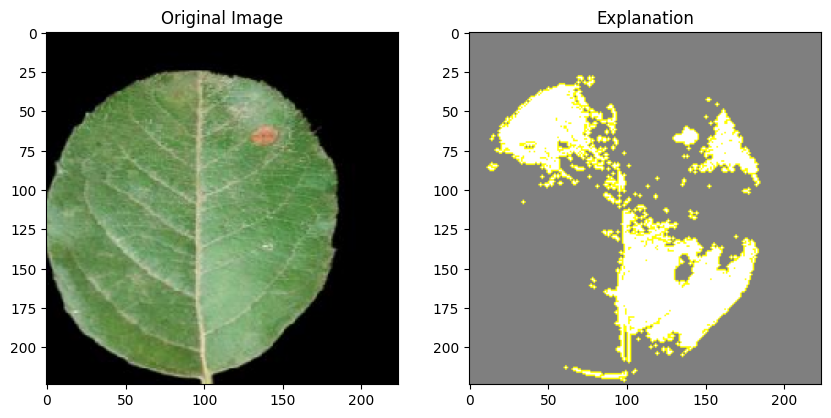

In [68]:
# Path to image file
image_path = '../data/filtered_diseases/test_filtered/alternaria_leaf_spot/000424.out.jpg'

# Assuming `patho_model_6` is your TensorFlow/Keras model
display_original_and_explanation(image_path, patho_model_10)

In [ ]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import preprocess_input

class_names = ['alternaria_leaf_spot', 'bacterial_spot', 'healthy', 'leaf_blight']  # Replace with your actual class names

def display_class_probabilities(model, img_path, class_names):
    # Load and preprocess the input data
    img = image.load_img(img_path, target_size=(224, 224)) 
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    # Get class probabilities
    probabilities = model.predict(img_array)[0]

    # Display class probabilities with class names
    for class_name, prob in zip(class_names, probabilities):
        print(f"{class_name}: {prob}")

display_class_probabilities(MODEL, IMAGE, class_names)